In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
# from Backups.old_system.train_and_test_linear import train_model as train_model_linear
# from Backups.old_system.train_and_test_conceptual import train_model as train_model_conceptual

In [3]:
save_dir = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/predictions/'


In [4]:
results_urls = glob(save_dir + '*')

In [18]:
matches = [all([i in url for i in ['r_0.0','gauge','48','f_5','u_0']]) for url in results_urls]
np.array(results_urls)[matches]


In [29]:
df_drainage = pd.read_pickle(f'./Data/drainage_Flow.pkl').drop(['MOS-HOL', 'KOP-HAB'], axis=1)

CTime
2015-01-01 00:00:00    324.141174
2015-01-01 01:00:00    394.048706
2015-01-01 02:00:00    302.678894
2015-01-01 03:00:00    359.589912
2015-01-01 04:00:00    342.063530
                          ...    
2021-10-30 22:00:00    167.446761
2021-10-30 23:00:00    142.027997
2021-10-31 00:00:00    175.194494
2021-10-31 01:00:00    124.244649
2021-10-31 02:00:00    126.187762
Name: RVK-GEL, Length: 59875, dtype: float64

In [41]:
obs_0 = np.load('./predictions/Observations_r_0.0_u_0_f_5_l_0.1_b_254_d_gauge_o_48.npy',allow_pickle=True).item()
iop_0 = np.load('C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/predictions\\Predictions_r_0.0_u_0_f_5_l_0.1_b_254_d_gauge_o_48.npy',allow_pickle=True).item()



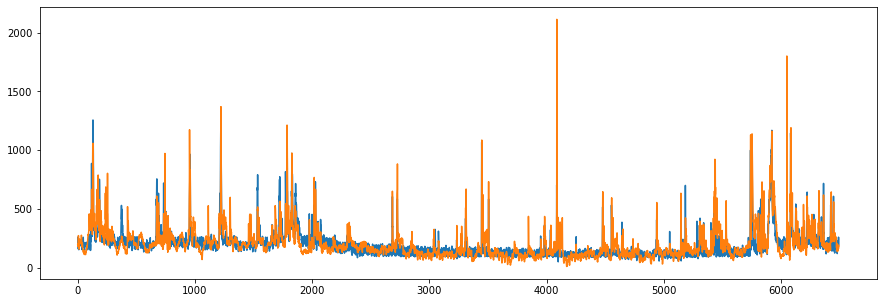

In [45]:
y_true = obs_0[0]['Y_val'][:,0]
y_pred = iop_0[0]['Y_val_pred'][:,0]

plt.figure(figsize=(15,5))
plt.plot(y_true)
plt.plot(y_pred)

# plt.plot(df_drainage.loc[:,'RVK-GEL'].values)

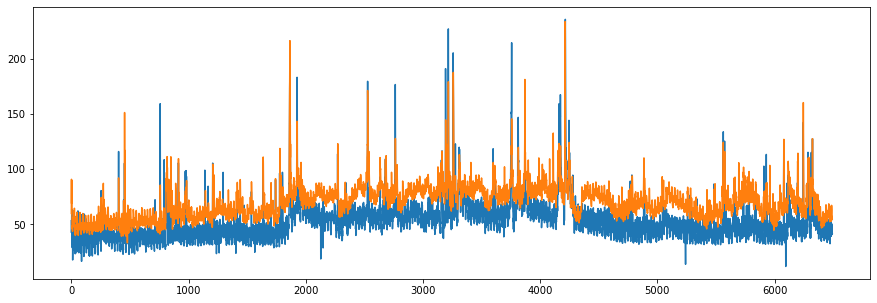

In [164]:
y_true = obs_0[2]['Y_val'][:,1]
y_pred = iop_0[2]['Y_val_pred'][:,1]

plt.figure(figsize=(15,5))
plt.plot(y_true)
plt.plot(y_pred)

# plt.plot(df_drainage.loc[:,'RVK-GEL'].values)

(5500.0, 6500.0)

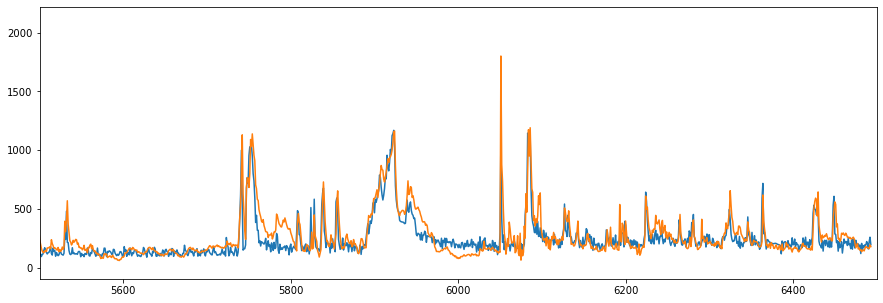

In [46]:
y_true = obs_0[0]['Y_val'][:,0]
y_pred = iop_0[0]['Y_val_pred'][:,0]

plt.figure(figsize=(15,5))
plt.plot(y_true)
plt.plot(y_pred)
plt.xlim(5500,6500)

# plt.plot(df_drainage.loc[:,'RVK-GEL'].values)

In [ ]:
y_true = obs_0[4]['Y_val'][:,0]
y_pred = iop_0[4]['Y_val_pred'][:,0]

plt.figure(figsize=(15,5))
plt.plot(y_true)
plt.plot(y_pred)
plt.xlim(3500,5000)

# plt.plot(df_drainage.loc[:,'RVK-GEL'].values)

In [77]:
def compute_GSS(y_pred_cls, y_true_cls):
    TP = np.sum(y_pred_cls & y_true_cls)
    FP = np.sum(y_pred_cls & ~y_true_cls)
    FN = np.sum(~y_pred_cls & y_true_cls)
    TP_rand = (TP + FN)*(TP + FP)/(len(y_true_cls))
    
    GSS = (TP - TP_rand)/(TP + FN + FP - TP_rand)
    return GSS

def get_best_GSS(iop_fold, thresh):
    Y_train_pred = iop_fold['Y_train_pred'][:,sensor]
    Y_val_pred = iop_fold['Y_val_pred'][:,sensor] 
    Y_train = iop_fold['Y_train'][:,sensor] 
    Y_val = iop_fold['Y_val'][:,sensor]
    
    Y_val_cls = Y_val > thresh
    Y_train_cls = Y_train > thresh
    
    GSS_list_train = []
    GSS_list_val = []
    sorted_pred = sorted(Y_train_pred)
    for t in sorted_pred:
        Y_train_pred_cls = Y_train_pred > t
        Y_val_pred_cls = Y_val_pred > t
        GSS_train = compute_GSS(Y_train_pred_cls,Y_train_cls)
        GSS_val = compute_GSS(Y_val_pred_cls,Y_val_cls)
        GSS_list_train.append(GSS_train)
        GSS_list_val.append(GSS_val)
        
    best_thresh = np.argmax(GSS_list_train)
    GSS_train_best = GSS_list_train[best_thresh]
    GSS_val_best = GSS_list_val[best_thresh]
    return GSS_train_best,GSS_val_best

def plt_GSS(iop_fold, thresh):
    Y_train_pred = iop_fold['Y_train_pred'][:,sensor]
    Y_val_pred = iop_fold['Y_val_pred'][:,sensor] 
    Y_train = iop_fold['Y_train'][:,sensor] 
    Y_val = iop_fold['Y_val'][:,sensor]
    
    Y_val_cls = Y_val > thresh
    Y_train_cls = Y_train > thresh
    
    GSS_list_train = []
    GSS_list_val = []
    sorted_pred = sorted(Y_train_pred)
    for t in sorted_pred:
        Y_train_pred_cls = Y_train_pred > t
        Y_val_pred_cls = Y_val_pred > t
        GSS_train = compute_GSS(Y_train_pred_cls,Y_train_cls)
        GSS_val = compute_GSS(Y_val_pred_cls,Y_val_cls)
        GSS_list_train.append(GSS_train)
        GSS_list_val.append(GSS_val)
        
    plt.plot(sorted_pred,GSS_list_train)
    plt.plot(sorted_pred,GSS_list_val)
    plt.legend(['Train','Validation'])
    plt.show()

def get_average_best_GSS(iop,thresh,sensor):
    best_GSS_train_list = []
    best_GSS_val_list = []
    for fold in iop:

        iop_fold = iop[fold]

        GSS_train_best,GSS_val_best = get_best_GSS(iop_fold,thresh)
        best_GSS_train_list.append(GSS_train_best)
        best_GSS_val_list.append(GSS_val_best)
    average_GSS_train = np.mean(best_GSS_train_list)
    average_GSS_val = np.mean(best_GSS_val_list)
    return average_GSS_train,average_GSS_val

In [157]:
obs_0[4]['Y_train'].shape,obs_0[4]['Y_val'].shape

for i in range(5):
    tmp_nse = nse(obs_0[i]['Y_val'][:,0],obs_0[i]['Y_val_pred'][:,0])
    print(tmp_nse)
print()
for i in range(5):
    tmp_nse = nse(obs_0[i]['Y_val'][:,1],obs_0[i]['Y_val_pred'][:,1])
    print(tmp_nse)
    
    
for i in range(5):
    tmp_nse = nse(obs_0[i]['Y_train'][:,0],obs_0[i]['Y_train_pred'][:,0])
    print(tmp_nse)
print()
for i in range(5):
    tmp_nse = nse(obs_0[i]['Y_train'][:,1],obs_0[i]['Y_train_pred'][:,1])
    print(tmp_nse)
    # nse(obs_0[4]['Y_val'][:,0],obs_0[4]['Y_val_pred'][:,0])

0.604020405634335
0.5059320267287992
0.38732345728442863
0.5967744166375297
0.5549392573731179

-3.853458845690522
0.19032396686552755
-0.9763819673897234
-0.4383956811228511
-1.0277950474733784
0.555496278039618
0.5266278341027005
0.5559291380452733
0.4681589679288424
0.3817605363363261

-3.2736213439124375
-0.2388456382276447
-0.44686000627317357
-0.6460883837438671
-0.45458962188115937


In [79]:
tmp_iop = obs_0.copy()
[tmp_iop[fold].update(iop_0[fold]) for fold in tmp_iop]
# tmp_iop

# fold = 4
        
sensor = 0
thresh = 500
get_average_best_GSS(tmp_iop,thresh,sensor)

(0.435165573684489, 0.4232508291827985)

In [95]:
iop_fold = tmp_iop[4]
Y_train_pred = iop_fold['Y_train_pred'][:,sensor]
Y_val_pred = iop_fold['Y_val_pred'][:,sensor] 
Y_train = iop_fold['Y_train'][:,sensor] 
Y_val = iop_fold['Y_val'][:,sensor]

Y_val_cls = Y_val > thresh
Y_train_cls = Y_train > thresh

GSS_list_train = []
GSS_list_val = []
sorted_pred = sorted(Y_train_pred)
tp_list = []
fp_list = []
fn_list = []
for t in sorted_pred:
    Y_train_pred_cls = Y_train_pred > t
    Y_val_pred_cls = Y_val_pred > t
    GSS_train = compute_GSS(Y_train_pred_cls,Y_train_cls)
    GSS_val = compute_GSS(Y_val_pred_cls,Y_val_cls)
    GSS_list_train.append(GSS_train)
    GSS_list_val.append(GSS_val)
    
    
    # For a test
    y_pred_cls = Y_val_pred_cls
    y_true_cls = Y_val_cls
    TP = np.sum(y_pred_cls & y_true_cls)
    FP = np.sum(y_pred_cls & ~y_true_cls)
    FN = np.sum(~y_pred_cls & y_true_cls)
    tp_list.append(TP)
    fp_list.append(FP)
    fn_list.append(FN)
    
best_thresh = np.argmax(GSS_list_train)
GSS_train_best = GSS_list_train[best_thresh]
GSS_val_best = GSS_list_val[best_thresh]

In [149]:
from hydroeval import nse

In [105]:
tp_list = np.array(tp_list)
fp_list = np.array(fp_list)
fn_list = np.array(fn_list)

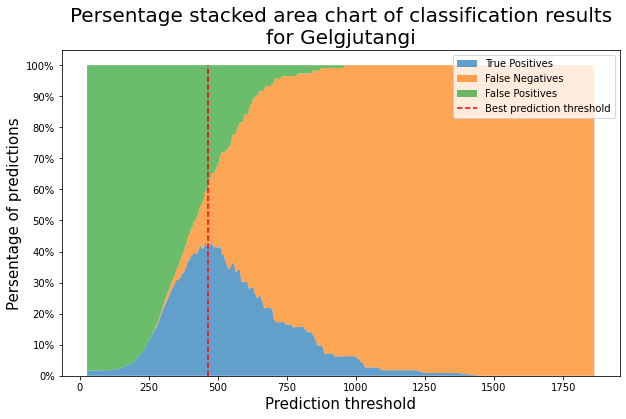

In [142]:
CSI = tp_list/(fn_list+fp_list+tp_list)
CSI_mod = (fn_list)/(fn_list+fp_list+tp_list)
TOT = (fp_list)/(fn_list+fp_list+tp_list)

plt.figure(figsize=(10,6))
plt.stackplot(sorted_pred,CSI,CSI_mod,TOT, labels=['True Positives','False Negatives','False Positives'],alpha = 0.7)

plt.xlabel('Prediction threshold',fontsize=15)
plt.ylabel('Persentage of predictions',fontsize=15)
plt.title('Persentage stacked area chart of classification results\nfor Gelgjutangi',fontsize=20)
plt.yticks(np.arange(0,1.01,0.1),[str(i) + '%' for i in np.arange(0,101,10)])
plt.vlines(sorted_pred[best_thresh],0,1,color='red',linestyles='--',label='Best prediction threshold')
plt.legend()
plt.show()

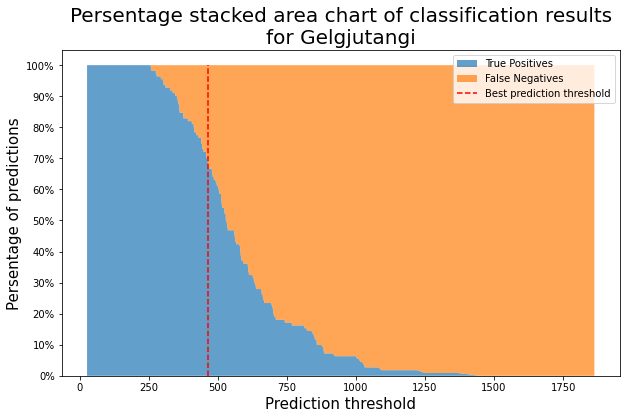

In [170]:
CSI = tp_list/(fn_list+tp_list)
CSI_mod = (fn_list)/(fn_list+tp_list)

plt.figure(figsize=(10,6))
plt.stackplot(sorted_pred,CSI,CSI_mod, labels=['True Positives','False Negatives','False Positives'],alpha = 0.7)

plt.xlabel('Prediction threshold',fontsize=15)
plt.ylabel('Persentage of predictions',fontsize=15)
plt.title('Persentage stacked area chart of classification results\nfor Gelgjutangi',fontsize=20)
plt.yticks(np.arange(0,1.01,0.1),[str(i) + '%' for i in np.arange(0,101,10)])
plt.vlines(sorted_pred[best_thresh],0,1,color='red',linestyles='--',label='Best prediction threshold')
plt.legend()
plt.show()

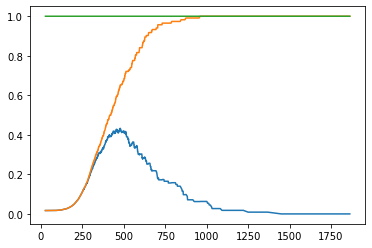

In [117]:
plt.plot(sorted_pred,tp_list/(fn_list+fp_list+tp_list),label = 'TP')
plt.plot(sorted_pred,(tp_list+fn_list)/(fn_list+fp_list+tp_list),label = 'TP')
plt.plot(sorted_pred,(fn_list+fp_list+tp_list)/(fn_list+fp_list+tp_list),label = 'TP')
# plt.plot(sorted_pred,GSS_list_val)

In [ ]:
plt.plot(sorted_pred,tp_list/(tp_list+fn_list),label = 'TP')

In [109]:
plt.plot(sorted_pred,tp_list/np.sum(tp_list),label = 'TP')
plt.plot(sorted_pred,(fp_list+tp_list)/,label = 'FP')
plt.plot(sorted_pred,(fn_list+fp_list+tp_list),label = 'FN')
plt.legend()


SyntaxError: invalid syntax (Temp/ipykernel_30636/1176162707.py, line 2)

In [93]:
t = sorted_pred[best_thresh]
Y_val_pred_cls = Y_val_pred > t
Y_val_cls = Y_val > thresh

y_pred_cls = Y_val_pred_cls
y_true_cls = Y_val_cls
TP = np.sum(y_pred_cls & y_true_cls)
FP = np.sum(y_pred_cls & ~y_true_cls)
FN = np.sum(~y_pred_cls & y_true_cls)

In [94]:
TP,FP,FN

(76, 73, 35)

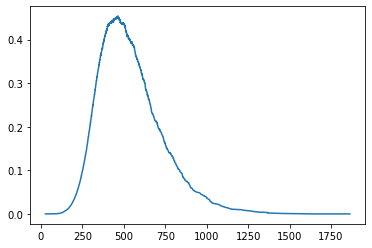

In [91]:
plt.plot(sorted_pred,GSS_list_train)

In [89]:
GSS_list_train[best_thresh],GSS_list_train[GSS_val_best]

TypeError: list indices must be integers or slices, not numpy.float64

In [84]:
GSS_train_best,GSS_val_best = get_best_GSS(tmp_iop[4],thresh)
GSS_train_best,GSS_val_best

(0.45367215509877123, 0.40480516515792747)

In [63]:
y_true = obs_0[4]['Y_val'][:,0]
y_pred = iop_0[4]['Y_val_pred'][:,0]


In [68]:
obs_0[4].keys()

dict_keys(['Y_val', 'Y_train', 'Y_val_pred', 'Y_train_pred'])

KeyError: 'Y_val'

In [17]:
# iop_0 = np.load('C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/predictions\\linear_model_same_nwp_rth_1.0_1.npy',allow_pickle=True).item()


In [76]:
iop_0[0]['Y_val_pred'][:,24:30].reshape(-1,2).shape

(4944, 2)

In [77]:
# Flatten the inputs
for fold in iop_0:
    iop_0[fold]['Y_train_pred'] = iop_0[fold]['Y_train_pred'][:,24:30].reshape(-1,2)
    iop_0[fold]['Y_val_pred'] = iop_0[fold]['Y_val_pred'][:,24:30].reshape(-1,2)
    iop_0[fold]['Y_train'] = iop_0[fold]['Y_train'][:,24:30].reshape(-1,2)
    iop_0[fold]['Y_val'] = iop_0[fold]['Y_val'][:,24:30].reshape(-1,2)

sensor = 0
thresh = 400
get_average_best_GSS(iop_0,thresh,sensor)

(0.2700659690343158, 0.2522107519003174)

In [7]:
# [i for i in results_urls if (('linear' in i) and all([k in i for k in ['1.0','1']]))]

In [8]:
iop_0 = np.load('C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/predictions\\linear_model_same_gauge_rth_1.0_3.npy',allow_pickle=True).item()

In [9]:
# [i for i in results_urls if (('conceptual' in i) and all([k in i for k in ['28','-4.331']]))]
# [i for i in results_urls if (('conceptual' in i) and all([k in i for k in ['NWP','f16','fin-3','ini-1','o3','a1.','same']]))]
[i for i in results_urls if (('conceptual' in i) and all([k in i for k in ['NWP','ba77',]]))]
# [i for i in results_urls if (('conceptual' in i) and all([k in i for k in ['gauge','rth','a1']]))]
# [i for i in results_urls if (('linear' in i) and all([k in i for k in ['NWP','',]]))]

['C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/predictions\\conceptual_model_wshi_mirror_dNWP_f17_o5_a2.243160444863869,_ini-0.29860942667777923_fin-4.460080474557293_ba77.npy',
 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/predictions\\conceptual_model_wshi_mirror_dNWP_f22_o6_a2.5278383078971465,_ini-0.3671136636923136_fin-3.4995584630748944_ba77.npy',
 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/predictions\\conceptual_model_wshi_mirror_dNWP_f42_o7_a1.241889207434686,_ini0.5940060990796527_fin-2.657776942677017_ba77.npy',
 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/predictions\\conceptual_model_wshi_mirror_dNWP_f9_o8_a17.008661279392708,_ini-0.06346512455883979_fin-1.6687613199207854_ba77.npy']

In [10]:
# best_conceptual_same = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/predictions\\conceptual_model_wsame_dNWP_f55_o3_a3.194,_ini-0.1535_fin-2.161_ba71.npy'
# best_conceptual_same = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/predictions\\conceptual_model_wsame_dNWP_f16_o3_a1.0,_ini-1.0_fin-3.0_ba64.npy'
# best_weighted = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/predictions\\conceptual_model_wshi_mirror_dNWP_f28_o3_a5.684965414943548,_ini-0.6437558491618967_fin-4.33105344144478_ba47.npy'
# best_weighted = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/predictions\\conceptual_model_wshi_mirror_dNWP_f22_o6_a2.5278383078971465,_ini-0.3671136636923136_fin-3.4995584630748944_ba77.npy'
# best_unweighted = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/predictions/'
# iop_0 = np.load('C:/Users/sverrirhd/model results\\linear_model_same_NWP_rth_1.3410276368965988_23.npy',allow_pickle=True).item()
# iop_0 = np.load(best_weighted,allow_pickle=True).item()
# iop_0 = np.load(best_conceptual_same,allow_pickle=True).item()

In [11]:
y_vals = []
y_pred = []
for fold in iop_0:
    y_vals.append(iop_0[fold]['Y_val'][:,0])
    y_pred.append(iop_0[fold]['Y_val_pred'][:,0])
y_vals = np.array(y_vals).ravel()
y_pred = np.array(y_pred).ravel()
print('sensor 0:',np.mean((y_vals - y_pred)**2))

y_vals = []
y_pred = []
for fold in iop_0:
    y_vals.append(iop_0[fold]['Y_val'][:,1])
    y_pred.append(iop_0[fold]['Y_val_pred'][:,1])
y_vals = np.array(y_vals).ravel()
y_pred = np.array(y_pred).ravel()
print('sensor 1:',np.mean((y_vals - y_pred)**2))

sensor 0: 5985.902963633862
sensor 1: 236.10067930102534


In [12]:
# np.mean([3371.7316409851114,
# 3215.910814112804,
# 4802.743132410866,
# 2325.695684469551,
# 1838.9278353588845,])

In [13]:
mses = []
for i in range(5):
    mse = np.mean((iop_0[i]['Y_val_pred'] - iop_0[i]['Y_val'])**2)
    mses.append(mse)
    print(mse)
print('average:',np.mean(mses))

3371.7316409851114
3215.910814112804
4802.743132410866
2325.695684469551
1838.9278353588845
average: 3111.0018214674433


In [14]:
# all_preds = []
# all_obs = []
# nses = {}
# for s in range(2):
#     nses_s = {}
#     for f in range(60):
#         obs_s_f = iop_0[0]['Y_val'][:,f,s]
#         pred_s_f = iop_0[0]['Y_val_pred'][:,f,s]
#         all_preds.append(pred_s_f)
#         all_obs.append(obs_s_f)
#         nse = he.evaluator(he.nse, pred_s_f, obs_s_f)
#         nses_s[f] = nse[0]
#     nses[s] = nses_s

# all_preds = np.concatenate(all_preds).ravel()
# all_obs = np.concatenate(all_obs).ravel()
# nse_all = he.evaluator(he.nse, all_preds, all_obs)

In [15]:
# nses_list = []
# for i in range(len(iop_0[0]['Y_val'])):
#     obs_s_f = iop_0[0]['Y_val'][i,:,0]
#     pred_s_f = iop_0[0]['Y_val_pred'][i,:,0]
#     nse = he.evaluator(he.nse, pred_s_f, obs_s_f)
#     nses_list.append(nse[0])
# plt.plot(nses_list)

In [16]:
# plt.hist(np.max(nses_list))

In [17]:
# pd.DataFrame(nses).plot()

In [18]:
# import hydroeval as he
# simulations = [5.3, 4.2, 5.7, 2.3]
# evaluations = [4.7, 4.3, 5.5, 2.7]

# nse = he.evaluator(he.nse, simulations, evaluations)


In [19]:
from evaluator import *
from helpers import sw_func

In [20]:
iop_0[0].keys()

dict_keys(['Y_train', 'Y_val', 'Y_train_pred', 'Y_val_pred'])

In [21]:
for i in iop_0:
    iop_0[i]['fold'] = i

In [22]:
threshold_dict = {
    "RVK-GEL": [0, 100, 200, 300, 400, 600, 800, 1000],
    "RVK-BOD": [0, 25, 50, 75, 100, 125, 150, 200],
}
thresholds = np.array(list(threshold_dict.values()))
relative_weights = [0.5, 1, 2, 5, 10, 15, 20, 30]
sample_weights_function = lambda x : sw_func(x, thresholds, relative_weights)


results = evaluate_results(iop_0,thresholds,sample_weights_function)

In [23]:
# iop_0

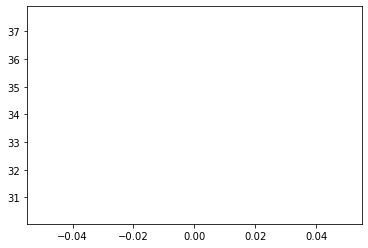

In [24]:
for i in range(5):
    plt.plot(results['folds'][i]['mean_absolute_error_profile'])

In [25]:
y_pred_list = []
y_list = []
for fold in iop_0:
    y_pred_list.append(iop_0[fold]['Y_val_pred'])
    y_list.append(iop_0[fold]['Y_val'])
y_preds_all = np.concatenate(y_pred_list).squeeze()
y_all = np.concatenate(y_list).squeeze()


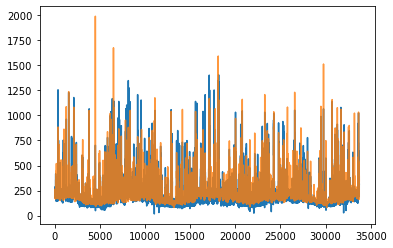

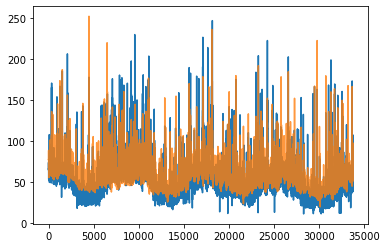

In [26]:
plt.plot(y_all[:,0].ravel())
plt.plot(y_preds_all[:,0].ravel(),alpha=0.8)
plt.show()
plt.plot(y_all[:,1].ravel())
plt.plot(y_preds_all[:,1].ravel(),alpha=0.8)
plt.show()

In [27]:
plt.plot(y_all[:,24:30,0].ravel())
plt.plot(y_preds_all[:,24:30,0].ravel(),alpha=0.8)
plt.show()
plt.plot(y_all[:,24:30,1].ravel())
plt.plot(y_preds_all[:,24:30,1].ravel(),alpha=0.8)
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
hours_pred = 24
plt.figure(figsize=(15,5))
plt.plot(y_all[:,24:30,0].ravel())
plt.plot(y_preds_all[:,24:30,0].ravel(),alpha=0.8)
# plt.xlim(20800,21500)
plt.xlim(22500,23500)
plt.legend(['Observed','Predictions 24 to 30 hours in advance'])
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

<Figure size 1080x360 with 0 Axes>

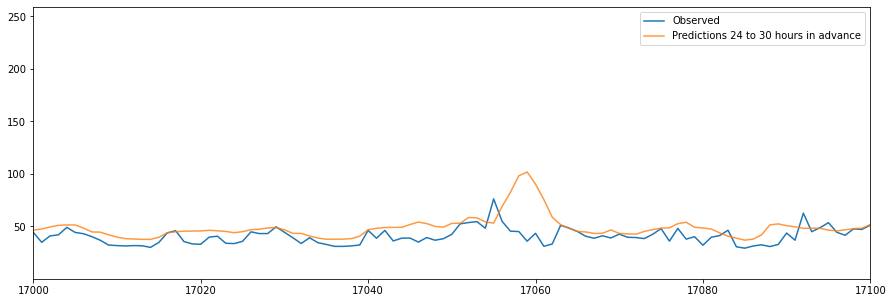

In [ ]:
hours_pred = 24
plt.figure(figsize=(15,5))
plt.plot(y_all[:,24:30,1].ravel())
plt.plot(y_preds_all[:,24:30,1].ravel(),alpha=0.8)
plt.xlim(17000,17100)
plt.legend(['Observed','Predictions 24 to 30 hours in advance'])
plt.show()

In [28]:

from evaluator import CLF_error
def classification_stats_dict(iop,thresh = 5,sensor = 0,pred_start = 0,pred_end = 60, prediction_thresholds = np.linspace(0,1,1000),future=True):
    eta = 1e-7
    
    if future:
        y_trues_val = np.concatenate([iop[fold]['Y_val_cls'] for fold in range(5)])[:,pred_start:pred_end, sensor, thresh].ravel()
        y_preds_val = np.concatenate([iop[fold]['Y_val_pred'] for fold in range(5)])[:,pred_start:pred_end, sensor].ravel()

        y_trues_train = np.concatenate([iop[fold]['Y_train_cls'] for fold in range(5)])[:,pred_start:pred_end, sensor, thresh].ravel()
        y_preds_train = np.concatenate([iop[fold]['Y_train_pred'] for fold in range(5)])[:,pred_start:pred_end, sensor].ravel()
    else:
        y_trues_val = np.concatenate([iop[fold]['Y_val_cls'] for fold in range(5)])[:, sensor, thresh].ravel()
        y_preds_val = np.concatenate([iop[fold]['Y_val_pred'] for fold in range(5)])[:, sensor].ravel()

        y_trues_train = np.concatenate([iop[fold]['Y_train_cls'] for fold in range(5)])[:, sensor, thresh].ravel()
        y_preds_train = np.concatenate([iop[fold]['Y_train_pred'] for fold in range(5)])[:, sensor].ravel()
        
    performance_dict_val = {}
    performance_dict_train = {}
    performance_dict_val['CSI'] = []
    performance_dict_train['CSI'] = []

    performance_dict_val['precision'] = []
    performance_dict_train['precision'] = []

    performance_dict_val['recall'] = []
    performance_dict_train['recall'] = []

    performance_dict_val['false positive rate'] = []
    performance_dict_train['false positive rate'] = []
    
    performance_dict_val['false negative rate'] = []
    performance_dict_train['false negative rate'] = []

    performance_dict_val['true positive rate'] = []
    performance_dict_train['true positive rate'] = []

    performance_dict_val['f1'] = []
    performance_dict_train['f1'] = []
    
    performance_dict_val['pred_thresh'] = []
    performance_dict_train['pred_thresh'] = []

    
    for pred_thresh in prediction_thresholds:
        TP, FP, TN, FN = CLF_error(y_trues_val, y_preds_val, pred_thresh)
        performance_dict_val['CSI'].append(TP/(TP + FP + FN + eta))
        performance_dict_val['precision'].append(TP/(TP+FP + eta))
        performance_dict_val['recall'].append(TP/(TP+FN + eta))
        performance_dict_val['false positive rate'].append(FP/(FP+TN + eta))
        performance_dict_val['true positive rate'].append(TP/(TP+FN + eta))
        performance_dict_val['f1'].append(TP/(TP + 1/2*(FP+FN + eta)))
        # performance_dict_val['false positive rate'].append(FN/(TP+FP))
    
        
    
        TP, FP, TN, FN = CLF_error(y_trues_train, y_preds_train, pred_thresh)
        performance_dict_train['CSI'].append(TP/(TP + FP + FN + eta))
        performance_dict_train['precision'].append(TP/(TP+FP + eta))
        performance_dict_train['recall'].append(TP/(TP+FN + eta))
        performance_dict_train['false positive rate'].append(FP/(FP+TN + eta))
        performance_dict_train['true positive rate'].append(TP/(TP+FN + eta))
        performance_dict_train['f1'].append(TP/(TP + 1/2*(FP+FN + eta)))
        # performance_dict_train['false positive rate'].append(FN/(TP+FP))
        
        
        performance_dict_val['pred_thresh'].append(pred_thresh)
        performance_dict_train['pred_thresh'].append(pred_thresh)
        

    performance_dict_val['y_trues_val'] = y_trues_val
    performance_dict_val['y_preds_val'] = y_preds_val
    performance_dict_val['y_trues_train'] = y_trues_train
    performance_dict_val['y_preds_train'] = y_preds_train
    return performance_dict_val,performance_dict_train

In [29]:
def get_classification_stats(iop_0,thresh,sensor,future=True):
    precision_val = []
    recall_val = []
    CSI_val = []
    FNR_val = []
    FPR_val = []

    precision_train = []
    recall_train = []
    CSI_train = []
    FNR_train = []
    FPR_train = []
    
    return_dict = {}
    # keys = [(0,6),(6,12),(12,24),(24,48),(48,60)]
    # keys = [(i*6,(i+1)*6) for i in range(60//6)]
    keys = [(24,30)]
    for pred_start,pred_end in keys:

        performance_dict_val,performance_dict_train = classification_stats_dict(
            iop_0,thresh,sensor,pred_start,pred_end,
            prediction_thresholds = np.linspace(0,1500,2000),
            future=future)
        
        precision_val.append(performance_dict_val['precision'])
        recall_val.append(performance_dict_val['recall'])
        CSI_val.append(performance_dict_val['CSI'])
        FNR_val.append(performance_dict_val['false negative rate'])
        FPR_val.append(performance_dict_val['false positive rate'])
        
        precision_train.append(performance_dict_train['precision'])
        recall_train.append(performance_dict_train['recall'])
        CSI_train.append(performance_dict_train['CSI'])
        FNR_train.append(performance_dict_train['false negative rate'])
        FPR_train.append(performance_dict_train['false positive rate'])
        
    return_dict['precision_val'] = np.array(precision_val)
    return_dict['recall_val'] = np.array(recall_val)
    return_dict['CSI_val'] = np.array(CSI_val)
    return_dict['NFR_val'] = np.array(FNR_val)
    return_dict['FPR_val'] = np.array(FPR_val)

    return_dict['precision_train'] = np.array(precision_train)
    return_dict['recall_train'] = np.array(recall_train)
    return_dict['CSI_train'] = np.array(CSI_train)
    return_dict['NFR_train'] = np.array(FNR_train)
    return_dict['FPR_train'] = np.array(FPR_train)
    
    return_dict['labels'] = [f'from {i} to {j}' for i,j in keys]
    return return_dict, performance_dict_val,performance_dict_train

# for fold in iop_0

# stats_dict,performance_dict_val,performance_dict_train = get_classification_stats(iop_0,4,1,future=False)
# stats_dict = get_classification_stats(iop_0,4,0)

# Add clf arrays to iop

In [30]:
for fold in iop_0:
    fold_data = iop_0[fold]
    fold_data['Y_train_cls'] = np.zeros(fold_data['Y_train'].shape + (8,))
    fold_data['Y_val_cls'] = np.zeros(fold_data['Y_val'].shape + (8,))
    for t1,t2 in thresholds.T:
        
        for i, (t1, t2) in enumerate(thresholds.T):
            fold_data['Y_train_cls'][:, 0, i] = (fold_data['Y_train'][:, 0] > t1)*1
            fold_data['Y_train_cls'][:, 1, i] = (fold_data['Y_train'][:, 1] > t2)*1
            
            fold_data['Y_val_cls'][:, 0, i] = (fold_data['Y_val'][:, 0] > t1)*1
            fold_data['Y_val_cls'][:, 1, i] = (fold_data['Y_val'][:, 1] > t2)*1

In [31]:
stats_dict,performance_dict_val,performance_dict_train = get_classification_stats(iop_0,5,0,future=False)

In [32]:
thresholds

array([[   0,  100,  200,  300,  400,  600,  800, 1000],
       [   0,   25,   50,   75,  100,  125,  150,  200]])

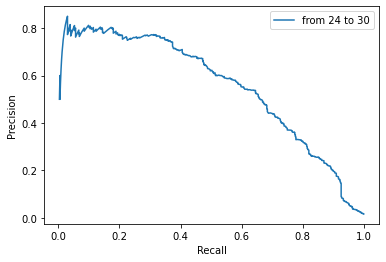

In [33]:
precision_val = stats_dict['precision_val']
recall_val = stats_dict['recall_val']
FPR_val = stats_dict['FPR_val']
labels = stats_dict['labels']
# precision_val = stats_dict['precision_val']
plt.plot(recall_val.T[:-5],precision_val.T[:-5])

# len(iop)
# no_skill = len(y_true_val[y_true_val==1]) / len(y_true_val)
# plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(labels + ['No skill'])



Text(0.5, 1.0, 'ROC curve')

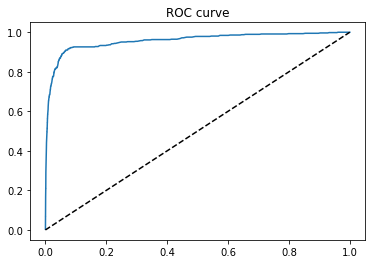

In [34]:
plt.plot(FPR_val.T,recall_val.T)
plt.plot([0,1],[0,1],linestyle='--',color='black')
plt.title('ROC curve')

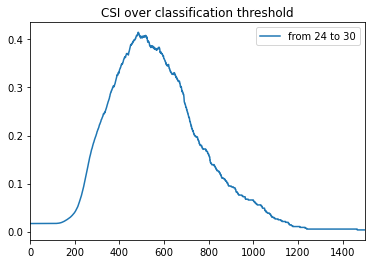

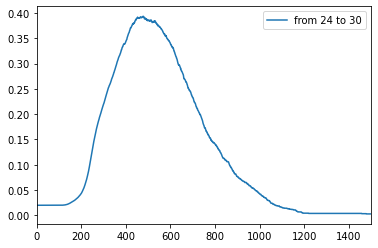

In [35]:
CSI_val = stats_dict['CSI_val']
CSI_train = stats_dict['CSI_train']
labels = stats_dict['labels']

plt.plot(np.linspace(0,1500,2000),CSI_val.T)
plt.xlim(0,1500)
plt.legend(labels)
plt.title('CSI over classification threshold')
plt.show()

plt.plot(np.linspace(0,1500,2000),CSI_train.T)
plt.xlim(0,1500)
plt.legend(labels)
plt.show()

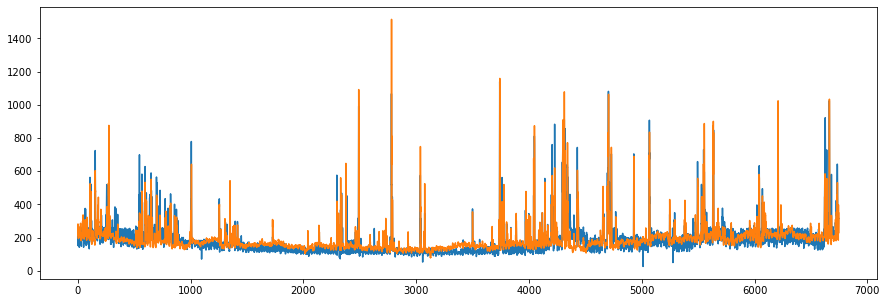

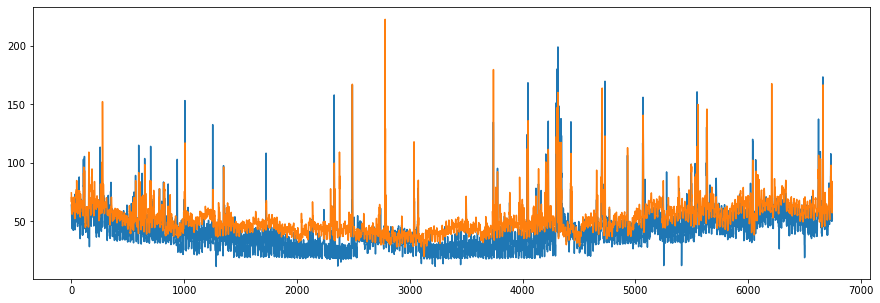

In [36]:

plt.figure(figsize=(15,5))
plt.plot(iop_0[4]['Y_val'][:,0])
plt.plot(iop_0[4]['Y_val_pred'][:,0])
plt.show()

plt.figure(figsize=(15,5))
plt.plot(iop_0[4]['Y_val'][:,1])
plt.plot(iop_0[4]['Y_val_pred'][:,1])
plt.show()

In [37]:
# plt.plot(performance_dict_train['recall'],performance_dict_train['precision'])
# plt.plot(performance_dict_val['recall'],performance_dict_val['precision'])

# no_skill = len(y_true_val[y_true_val==1]) / len(y_true_val)
# plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# plt.xlabel('Recall (Sensitivity)')
# plt.ylabel('Precisioin')
# plt.legend(['Train','Validation','No skill'])
# plt.show()

# plt.plot(performance_dict_train['false positive rate'],performance_dict_train['true positive rate'])
# plt.plot(performance_dict_val['false positive rate'],performance_dict_val['true positive rate'])
# plt.plot([0,1],[0,1], linestyle='--', label='No Skill')
# plt.xlabel('Recall (Sensitivity)')
# plt.ylabel('Precisioin')
# plt.legend(['Train','Validation','no skill'])
# plt.show()

# plt.plot(prediction_thresholds,performance_dict_train['f1'])
# plt.plot(prediction_thresholds,performance_dict_val['f1'])
# plt.xlabel('Threshold')
# plt.ylabel('F1 score')
# plt.legend(['Train','Validation','no skill'])
# plt.show()

In [38]:
# file_name = f'linear_model_{args.weights}_{args.datasource}_{args.include}_{args.alpha}_{args.obs}'
#     np.save(save_dir + file_name,linear_results['iop'], allow_pickle=True)

In [39]:
class simplest_clsasifier():
    def __init__(self):
        pass
    def fit(self,X,Y):
        self.x_max = X.max(axis=0)
        self.x_min = X.min(axis=0)
    
    def predict(self,X):
        return (X-self.x_min)/(self.x_max - self.x_min)

In [40]:
def compute_classification_simple(fold_data,config):
    thresholds = np.array(config['thresholds'])
    
    # Less hassle to infer prediction distance than to pass through with everything else
    if fold_data['Y_train_pred'].ndim == 2:
        pred_dist = 1
    elif fold_data['Y_train_pred'].ndim == 3:
        pred_dist = fold_data['Y_train_pred'].shape[1]
        
    n_thresh = thresholds.shape[1]
    
    # sigmoid output
    # classification_layer = Sequential([
    #     Input((pred_dist, 2)),
    #     Reshape((pred_dist, 2, 1)),
    #     Conv1D(n_thresh, 1, activation='sigmoid'),
    # ], 'classification_output')
    
    # classification_layer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    #                              loss=tf.losses.binary_crossentropy)
    classification_layer = simplest_clsasifier()
    fold_data['Y_train_cls'] = np.zeros(fold_data['Y_train'].shape + (8,))
    fold_data['Y_val_cls'] = np.zeros(fold_data['Y_val'].shape + (8,))
    for i, (t1, t2) in enumerate(thresholds.T):
        fold_data['Y_train_cls'][:, :, 0, i] = (fold_data['Y_train'][:, :, 0] > t1)*1
        fold_data['Y_train_cls'][:, :, 0, i] = (fold_data['Y_train'][:, :, 1] > t2)*1
        
        fold_data['Y_val_cls'][:, :, 0, i] = (fold_data['Y_val'][:, :, 0] > t1)*1
        fold_data['Y_val_cls'][:, :, 0, i] = (fold_data['Y_val'][:, :, 1] > t2)*1

    # n_epochs = 10
    # lr_list = np.logspace(-1,-6,n_epochs)
    # scheduler = lambda epoch, lr: lr_list[epoch]
    # lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

    # classification_layer.fit(fold_data['Y_train_pred'].reshape(-1,pred_dist,2),
    #                         fold_data['Y_train_cls'],
    #                         epochs = n_epochs,
    #                         batch_size = 5,
    #                         validation_data = (fold_data['Y_val_pred'].reshape(-1,pred_dist,2), fold_data['Y_val_cls']),
    #                         callbacks = [lr_scheduler],
    #                         verbose = 1)
    
    classification_layer.fit(fold_data['Y_train_pred'].reshape(-1,pred_dist,2),
                            fold_data['Y_train_cls'],)
    
    fold_data['Y_train_pred_cls'] = classification_layer.predict(fold_data['Y_train_pred'].reshape(-1,pred_dist,2))
    fold_data['Y_val_pred_cls'] = classification_layer.predict(fold_data['Y_val_pred'].reshape(-1,pred_dist,2))
    

# PIPELINE FOR CLASSIFICATION PERFORMANCE

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from train_and_test_conceptual import train_model
from train_and_test import compute_classification
save_dir = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/predictions/'
results_urls = glob(save_dir + '*')
threshold_dict = {
    "RVK-GEL": [0, 100, 200, 300, 400, 600, 800, 1000],
    "RVK-BOD": [0, 25, 50, 75, 100, 125, 150, 200],
}
thresholds = np.array(list(threshold_dict.values()))
relative_weights = [0.5, 1, 2, 5, 10, 15, 20, 30]
sample_weights_function = lambda x : sw_func(x, thresholds, relative_weights)
config = {'thresholds' : thresholds}

stats = {}
for results_url in results_urls[:10]:
    print(results_url)
    iop = np.load(results_url,allow_pickle=True).item()
    for i in iop:
        iop[i]['fold'] = i
            
    results = evaluate_results(iop,thresholds,sample_weights_function)
    
    y_pred_list = []
    y_list = []
    for fold in iop:
        y_pred_list.append(iop[fold]['Y_val_pred'])
        y_list.append(iop[fold]['Y_val'])
    y_preds_all = np.concatenate(y_pred_list).squeeze()
    y_all = np.concatenate(y_list).squeeze()

    for i in range(5):
        compute_classification_simple(iop[i],config)
    sensor_stats = {}
    for thresh in range(8):
        for sensor in range(2):
            clf_stats = get_classification_stats(thresh,sensor)
            sensor_stats[(thresh,sensor)] = clf_stats
            
    stats[results_url] = sensor_stats
    


C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/predictions\conceptual_model_same_NWP_16_1.npy


TypeError: get_classification_stats() missing 1 required positional argument: 'sensor'

In [42]:
for val in stats.values():
    plt.plot(val[(4,1)]['CSI_val'])
    print(val[(5,1)]['CSI_val'])

# Invesitating bad conceptual model performance for rain-gauge data

In [4]:
from tensorflow.keras import Sequential,Model
# from tensorflow.keras.layers import Dense, Input, Conv1D, Add,Reshape, Flatten, Lambda
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow import random, losses
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping
from tensorflow.keras.regularizers import l2,l1
from tensorflow import device
import tensorflow as tf
import numpy as np


class conceptual_model_2():
    def __init__(self, config,  **kwargs):
        self.config = config
        random.set_seed(self.config['random_seed'])
        
        if config['datasource'] == 'NWP':
            p = 100
            Input(shape = (config['pred_dist'],  p)),
            timesteps = config['pred_dist']
            padding = 'causal'
            
        else:
            if config['datasource'] == 'radar':
                p = 400
            elif config['datasource'] == 'gauge':
                p = 1
            timesteps = config['obs']
            padding = 'valid'
            
        if ((config['datasource'] == 'radar') or (config['datasource'] == 'NWP')):
            RR = Sequential([
                Input(shape = (timesteps,  p)),
                # Lambda(lambda x : tf.gather(x,[189,190,191,209,210,211,229,230,231],axis=-1)),
                Conv1D(
                    filters=config['filters'],
                    kernel_size=1,
                    padding=padding,
                    # activation='sigmoid',
                    activation='sigmoid',
                    # kernel_regularizer=l1(
                    #     config['alpha']
                    #     ),
                    kernel_regularizer=l2(
                        config['alpha']
                        ),
                    # kernel_constraint=tf.keras.constraints.NonNeg()
                    ),
                
                # Flatten(),
                Permute((2,1)),
                LocallyConnected1D(1,1,1),
                Flatten(),
                # Dense(2,activation='linear'),
                # Reshape((-1,2))
                ],
                            'rainfall')
        else:
            RR = Sequential([
                Input(shape = (timesteps,  p)),
                Flatten(),
                Dense(2,activation='linear'),
                # Reshape((-1,2))
                ],
                            'rainfall')
            
        # DH = Sequential([
        #     Input((timesteps, 1)),
        #     Conv1D(filters = 50,
        #            kernel_size = 1,
        #            padding=padding,
        #            activation='relu',
        #            ),
        #     Flatten(),
        #     Dense(units=2,
        #           activation = 'relu',),
        #     # Reshape((-1,2)),
        #     ], name='district_heating')
        
        DH = Sequential([
            Input((timesteps, 1)),
            # Conv1D(filters = 1,
            #        kernel_size = 1,
            #        padding=padding,
            #        activation='linear',
            #        ),
            Flatten(),
            Dense(units=2,
                  activation = 'linear',),
            # Reshape((-1,2)),
            ], name='district_heating')

        DP = Sequential([
            Input((timesteps, 24)),
            Conv1D(filters = 2,
                #    kernel_size = 1,
                   kernel_size = 1,
                   padding=padding,
                   activation='linear'),
            Flatten(),
            # Reshape((-1,2)),
            Dense(2)
            ])
        
        # inputs
        
        RR_input = Input((timesteps, p), name='rainfall_input')
        DH_input = Input((timesteps, 1,), name='DH_input')
        DP_input = Input((timesteps, 24), name='pattern_input')

        RR_output = RR(RR_input)
        DH_output = DH(DH_input)
        DP_output = DP(DP_input)

        combined_output = Add()([RR_output,DH_output,DP_output])
        # combined_output = RR_output
        
        
        self.model = Model([RR_input,DH_input,DP_input],combined_output)
        self.optimizer = Adam()
        self.model.compile(optimizer=self.optimizer,
                           loss=losses.MSE)

        self.lr_scheduler = LearningRateScheduler(self.lr_schedule, verbose=0)
        self.early_stopper = EarlyStopping(**config['early_stopper'])
        self.keywordarguments = {
            'epochs' : config['epochs'],
            'batch_size' : config['batch_size'],
            'shuffle' : True,
            'callbacks' : [
                self.lr_scheduler,
                self.early_stopper
                ],
        }
        
    def lr_schedule(self, epoch, lr):
        learning_rates = np.logspace(self.config['lr_inital_log'],
                                    self.config['lr_final_log'],
                                    self.config['lr_intervals'])
        epochs = self.config['epochs']
        return learning_rates[int(epoch/epochs * self.config['lr_intervals'])]

    
    def fit(self, fold_data, weight_func, debug = False):
        '''
            X : [(n_batches, n_forecast, n_variables),
                (n_batches, n_forecast, 1),
                (n_batches, n_forecast, 24)]
                = [rainfall, temperature, one-hot-encoded time of day]
            Y : (n_batches, n_forecasts, n_sensors)
            --- 
            Rainfall-runoff shape at each step
            Input shape:
            (n_batches, n_forecast, n_variables),
            Conv1D with with causal padding and kernel size = obs:
            (n_batches, n_forecast, n_filters)
            After Dense:
            (n_batches, n_forecast, n_sensors)    
            
            District heating shape at each step
            Input shape:
            (n_batches, n_forecast, 1),
            Dense:
            (n_batches, n_forecast, n_sensors)
            
            Daily pattern at each step
            Input shape:
            (n_batches, n_forecast, 24),
            Dense:
            (n_batches, n_forecast, n_sensors)
        '''
        X = fold_data['X_train']
        Y = fold_data['Y_train'] 
        X_val = fold_data['X_val']
        Y_val = fold_data['Y_val'] 
            
        fold_data['sample_weights'] = weight_func(Y)
            
        verbose = 0
        if debug:
            verbose = 1
        self.model.fit(X,Y,
                    validation_data = (X_val,Y_val),
                    sample_weight=fold_data['sample_weights'],
                    verbose = verbose,
                    **self.keywordarguments,)

    def predict(self, X):
        Y_pred = self.model.predict(X)
        return Y_pred

    

In [12]:
from tensorflow.keras.utils import plot_model
# from models.conceptual_model import conceptual_model
config_conceptual = {
        "name": "Conceptual model",
        "cross_validation": {
            "fn_kfold": 'TimeSeriesSplit',
            "folds": 5,
        },
        "thresholds": np.array([[   0,  100,  200,  300,  400,  600,  800, 1000],
                                [   0,   25,   50,   75,  100,  125,  150,  200]]),
        'early_stopper': {
            'monitor': 'val_loss',
            'min_delta': 0,
            'patience': 20,
            'verbose': 0,
            'mode': 'min',
            'baseline': None,
            'restore_best_weights': True,
            }
,
        'lr_inital_log': 0,
        'lr_final_log': -3,
        'lr_intervals': 100,
        'batch_size': 512,
        # 'batch_size': 48,
        'epochs': 120,
        'random_seed':0,
        'pred_dist':60,
        'include' : 'rth',
        # CLI args
        'datasource':'radar',
        # 'datasource':'gauge',
        'obs':10,
        'filters':2,
        'alpha':1,
    }
model = conceptual_model_2(config_conceptual)

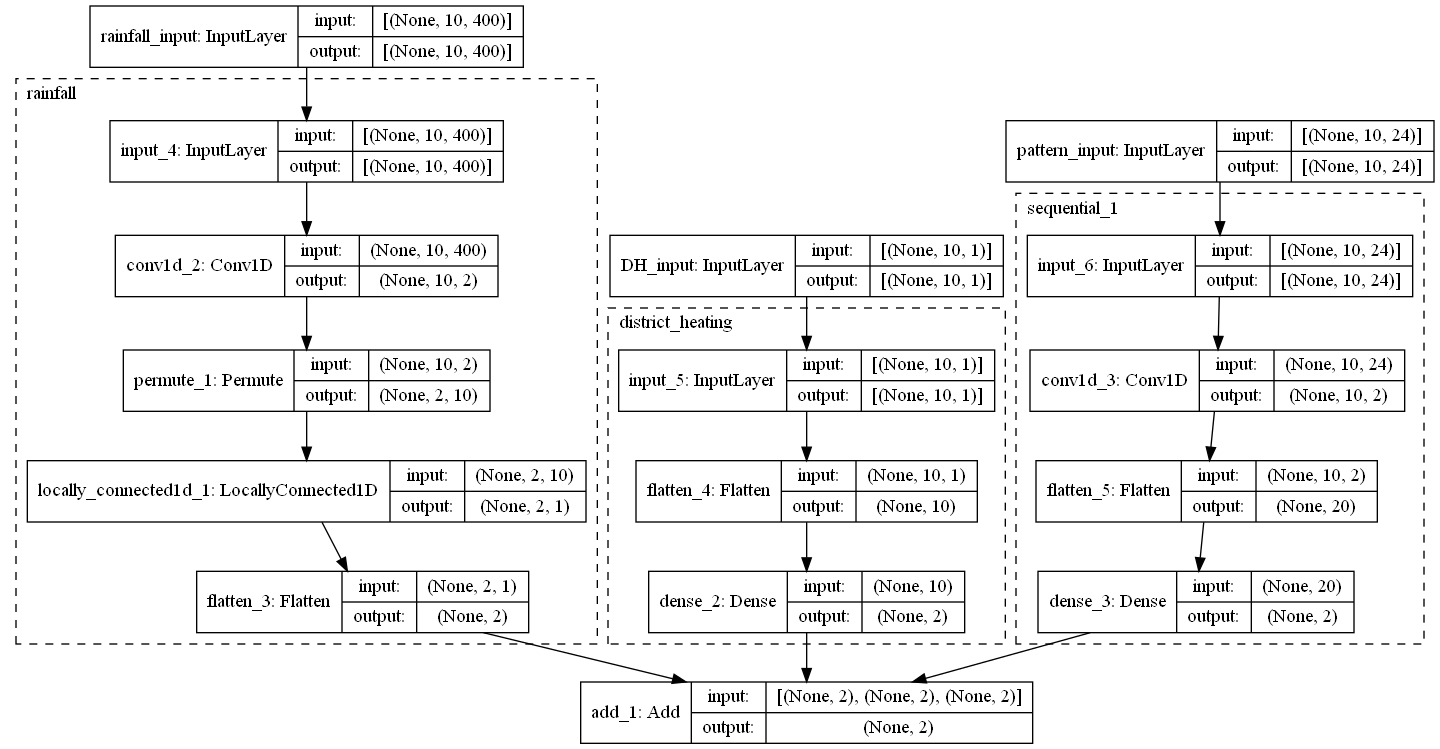

In [13]:
plot_model(model.model,expand_nested=True,show_shapes=True)

In [14]:
config_conceptual['datasource']

'radar'

In [15]:
from helpers import get_rain_gauge_or_radar_data
import datetime

temperature_name = "1475_T"
n_obs = config_conceptual['obs']
d_start = datetime.datetime(2015, 1, 1)
d_end = datetime.datetime(2019, 12, 31, 23, 59, 59)
threshold_dict = {
    "RVK-GEL": [0, 100, 200, 300, 400, 600, 800, 1000],
    "RVK-BOD": [0, 25, 50, 75, 100, 125, 150, 200],
}

thresholds = np.array(list(threshold_dict.values()))
pred_dist_tmp = 1


# Data source argument
if config_conceptual['datasource'] == "NWP":
    X1, X2, X3, Y12 = get_NWP_data(threshold_dict,temperature_name,
                                    max_lag,pred_dist,d_start,d_end,)
    rain_shape = (-1, pred_dist, 100)
    temp_shape = (-1, pred_dist, 1)
    patt_shape = (-1, pred_dist, 24)
elif config_conceptual['datasource'] == "radar":
    pred_dist_tmp = 1
    X1,_,X2,X3,Y12 = get_rain_gauge_or_radar_data(
        threshold_dict,
        temperature_name,
        n_obs,
        d_start,d_end,)
    rain_shape = (-1, n_obs, 20*20)
    temp_shape = (-1, n_obs, 1)
    patt_shape = (-1, n_obs, 24)
elif config_conceptual['datasource'] == "gauge":
    pred_dist_tmp = 1
    _,X1,X2,X3,Y12 = get_rain_gauge_or_radar_data(
        threshold_dict,
        temperature_name,
        n_obs,
        d_start,d_end,)
    rain_shape = (-1, n_obs, 1)
    temp_shape = (-1, n_obs, 1)
    patt_shape = (-1, n_obs, 24)

        
input_data = [
    X1.reshape(rain_shape),
    X2.reshape(temp_shape),
    X3.reshape(patt_shape),
]
if type(Y12) == list:
    index = np.arange(0,len(Y12[0]))
else:
    index = np.arange(0,len(Y12))
    
    


In [16]:
from helpers import apply_scaling, apply_indexes, MinMaxScaler
import sklearn
standardizer=MinMaxScaler

models, input_output_pred = {}, {}
fn_crossval = config_conceptual['cross_validation']['fn_kfold']
fn_crossval_instance = getattr(sklearn.model_selection, fn_crossval)
cross_val = fn_crossval_instance(5)

for i, (train, val) in enumerate(cross_val.split(index)):

    fold_data = {}
    fold_data['fold'] = i

    input_data_scaled = apply_scaling(input_data,train,standardizer)
    fold_data['X_train'], fold_data['X_val'] = apply_indexes(input_data_scaled, train, val, lambda x : x)
    fold_data['Y_train'], fold_data['Y_val'] = apply_indexes(Y12, train, val, lambda x : x)
            
    input_output_pred[i] = fold_data
    
from helpers import sw_func
relative_weights = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
sample_weights_function = lambda x : sw_func(x, thresholds, relative_weights)
    

In [17]:
input_output_pred[0]['X_train'][0].shape,input_output_pred[0]['X_train'][1].shape,input_output_pred[0]['X_train'][1].shape

((6700, 10, 400), (6700, 10, 1), (6700, 10, 1))

In [18]:
input_output_pred[0]['X_train'][0].shape

(6700, 10, 400)

ModuleNotFoundError: No module named 'wradlib'

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
2015-01-01 00:00:00,-15.2,-13.6,-12.4,-14.0,-13.6,-10.4,-11.2,-3.2,-3.6,-2.8,...,14.0,13.6,14.0,14.4,14.0,11.6,11.6,12.0,11.6,12.4
2015-01-01 00:15:00,-13.2,-14.4,-12.8,-13.2,-14.4,-4.0,-10.4,-8.0,-7.6,-8.0,...,6.0,5.2,6.8,9.6,9.2,8.0,7.2,6.0,4.8,2.8
2015-01-01 00:30:00,12.4,13.6,12.8,11.6,11.6,9.6,7.6,6.4,6.0,6.0,...,-4.4,-4.8,-15.6,-26.0,-26.4,-30.0,-30.0,-27.6,-23.2,-20.0
2015-01-01 00:45:00,15.2,15.2,14.8,13.2,13.2,12.8,13.2,10.8,10.4,10.8,...,-28.4,-25.2,-13.6,-16.8,-23.2,-30.0,-30.0,-30.0,-20.0,-16.8
2015-01-01 01:00:00,16.0,15.6,16.0,15.6,15.6,13.6,14.8,14.0,14.0,14.0,...,3.6,4.4,3.6,2.8,3.2,-0.8,0.0,0.0,1.2,-0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 23:35:00,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-25.0,...,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-28.0,-30.0,-26.0,-25.0
2019-12-31 23:40:00,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,...,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-5.5
2019-12-31 23:45:00,-29.0,-26.5,-29.5,-26.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,...,-12.5,-30.0,-32.0,-32.0,-32.0,-32.0,-32.0,-30.0,-27.0,-22.0
2019-12-31 23:50:00,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,-32.0,...,-8.0,-5.5,-4.5,-9.0,-23.5,-30.0,-32.0,-31.0,-29.0,-24.0


In [19]:
model.fit(input_output_pred[4],sample_weights_function,True)

Epoch 1/120
66/66 [==============================] - 2s 17ms/step - loss: 8535.2646 - val_loss: 3738.2444
Epoch 2/120
66/66 [==============================] - 1s 12ms/step - loss: 7166.9790 - val_loss: 5229.6577
Epoch 3/120
66/66 [==============================] - 1s 11ms/step - loss: 7518.2944 - val_loss: 2888.4099
Epoch 4/120
66/66 [==============================] - 1s 11ms/step - loss: 6278.6714 - val_loss: 3026.5161
Epoch 5/120
66/66 [==============================] - 1s 11ms/step - loss: 6248.5059 - val_loss: 3491.7302
Epoch 6/120
66/66 [==============================] - 1s 10ms/step - loss: 6234.3682 - val_loss: 2809.2600
Epoch 7/120
66/66 [==============================] - 1s 10ms/step - loss: 6731.9985 - val_loss: 3683.8755
Epoch 8/120
66/66 [==============================] - 1s 10ms/step - loss: 6923.1362 - val_loss: 2938.1882
Epoch 9/120
66/66 [==============================] - 1s 10ms/step - loss: 6006.8130 - val_loss: 2809.3281
Epoch 10/120
66/66 [==========================

In [198]:
mweight = model.model.weights
[i.shape for i in mweight]

[TensorShape([1, 400, 2]),
 TensorShape([2]),
 TensorShape([2, 20, 1]),
 TensorShape([2, 1]),
 TensorShape([20, 2]),
 TensorShape([2]),
 TensorShape([1, 24, 2]),
 TensorShape([2]),
 TensorShape([40, 2]),
 TensorShape([2])]

In [202]:
import matplotlib.pyplot as plt
map_weights = mweight[0].numpy().squeeze().reshape(20,20,2)
map_weights.shape

(20, 20, 2)

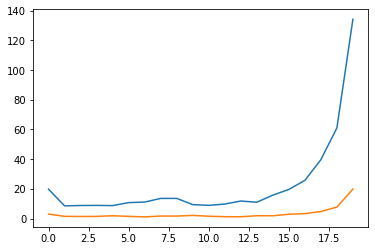

In [206]:
plt.plot(mweight[2].numpy().squeeze().T)

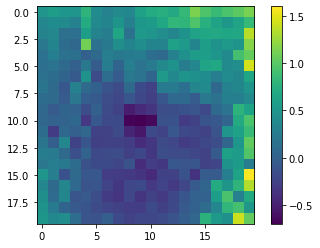

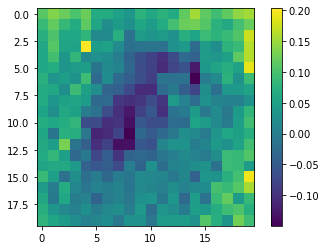

In [204]:

plt.imshow(map_weights[:,:,0])
plt.colorbar()
plt.show()
plt.imshow(map_weights[:,:,1])
plt.colorbar()
plt.show()

In [113]:
from sklearn.linear_model import Ridge
reg = Ridge(0)
reg.fit(input_output_pred[0]['X_train'][0].squeeze().reshape(-1,400*5),
        # [:,:,[189,190,191,209,210,211,229,230,231]].reshape(-1,9*20),
        input_output_pred[0]['Y_train'])

y_pred = reg.predict(input_output_pred[0]['X_train'][0].reshape(-1,400*5)
                    #  [:,:,[189,190,191,209,210,211,229,230,231]].reshape(-1,9*20)
                     )
y_true = input_output_pred[0]['Y_train']
print(np.mean((y_pred - y_true)**2))

y_pred = reg.predict(input_output_pred[0]['X_val'][0].reshape(-1,400*5)
                    #  [:,:,[189,190,191,209,210,211,229,230,231]].reshape(-1,9*20)
                     )
y_true = input_output_pred[0]['Y_val']
print(np.mean((y_pred - y_true)**2))


2791.859335614106
10822.329244523002


In [89]:
# from sklearn.linear_model import Ridge
# reg = Ridge()
# reg.fit(input_output_pred[0]['X_train'][0].squeeze().reshape(-1,400*5),input_output_pred[0]['Y_train'])

# y_pred = reg.predict(input_output_pred[0]['X_train'][0].reshape(-1,400*5))
# y_true = input_output_pred[0]['Y_train']
# print(np.mean((y_pred - y_true)**2))

# y_pred = reg.predict(input_output_pred[0]['X_val'][0].reshape(-1,400*5))
# y_true = input_output_pred[0]['Y_val']
# print(np.mean((y_pred - y_true)**2))


In [139]:
keywordarguments

{'epochs': 60,
 'batch_size': 1,
 'shuffle': True,
 'callbacks': [<keras.callbacks.LearningRateScheduler at 0x1eebdd71550>,
  <keras.callbacks.EarlyStopping at 0x1eebd2ed4f0>]}

In [81]:
# from tensorflow.keras.optimizers import Adam
# keywordarguments = {
#     'epochs' : config_conceptual['epochs'],
#     'batch_size' : config_conceptual['batch_size'],
#     'shuffle' : True,
#     'callbacks' : [
#         model.lr_scheduler,
#         model.early_stopper
#         ],
# }

# RR = Sequential([
#     Input(shape = (20,  400)),
#     Flatten(),
#     Dense(2,activation='linear'),
#     # Reshape((-1,2))
#     ],
#     'rainfall')

# RR.compile(optimizer=Adam(),
#                     loss=losses.MSE)

# RR.fit(input_output_pred[1]['X_train'][0],
#        input_output_pred[1]['Y_train'],
#         validation_data = (input_output_pred[1]['X_val'][0],input_output_pred[1]['Y_val']),
#        **keywordarguments)

# # 

Epoch 1/60
552/552 [==============================] - 1s 2ms/step - loss: 19944.9941 - val_loss: 25409.2129
Epoch 2/60
552/552 [==============================] - 1s 2ms/step - loss: 19361.4004 - val_loss: 11444.8682
Epoch 3/60
552/552 [==============================] - 1s 2ms/step - loss: 12217.7139 - val_loss: 13566.4893
Epoch 4/60
552/552 [==============================] - 1s 2ms/step - loss: 12453.2725 - val_loss: 8387.9453
Epoch 5/60
552/552 [==============================] - 1s 1ms/step - loss: 10218.3916 - val_loss: 22542.6914
Epoch 6/60
552/552 [==============================] - 1s 2ms/step - loss: 11407.1953 - val_loss: 6866.4878
Epoch 7/60
552/552 [==============================] - 1s 2ms/step - loss: 10380.8320 - val_loss: 7055.1909
Epoch 8/60
552/552 [==============================] - 1s 2ms/step - loss: 9021.6943 - val_loss: 8877.0186
Epoch 9/60
552/552 [==============================] - 1s 2ms/step - loss: 7629.7471 - val_loss: 7750.3345
Epoch 10/60
552/552 [==============

KeyboardInterrupt: 

In [93]:
from helpers import *

GD_dirname = find_experiment_directory()
df_gauge = pd.read_pickle(f'{GD_dirname}/Data/rain_gauges_combined.pkl')    



pred_dist_tmp = 1
dates = get_rain_gauge_or_radar_data(
    threshold_dict,
    temperature_name,
    20,
    d_start,d_end,return_just_dates=True)

X1,_,X2,X3,Y12 = get_rain_gauge_or_radar_data(
    threshold_dict,
    temperature_name,
    20,
    d_start,d_end,return_just_dates=False)



In [99]:
X1.shape

(39743, 20, 400)

In [102]:
X_radar_tmp = X1[:,-1,[189,190,191,209,210,211,229,230,231]].sum(axis=1)
X_gauge_tmp = df_gauge.loc[:,'1475_R_manual']

r_series = pd.Series(X_radar_tmp,index = dates[:,-1])
r_series.shift(0).corr(X_gauge_tmp)

0.6207790245540851

In [28]:
from sklearn.linear_model import Ridge
reg = Ridge()

reg.fit(X_radar_tmp,input_output_pred[0]['Y_train'])

y_pred = reg.predict(input_output_pred[0]['X_train'][0][:,:,[189,190,191,209,210,211,229,230,231]].reshape(-1,9*20))
y_true = input_output_pred[0]['Y_train']
print(np.mean((y_pred - y_true)**2))

y_pred = reg.predict(input_output_pred[0]['X_val'][0][:,:,[189,190,191,209,210,211,229,230,231]].reshape(-1,9*20))
y_true = input_output_pred[0]['Y_val']
print(np.mean((y_pred - y_true)**2))


array([3.19860491, 4.97038806, 4.07616584, ..., 3.49902117, 2.56587287,
       1.84971247])

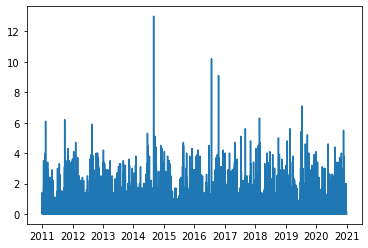

In [41]:
plt.plot()
plt.plot(df_gauge.loc[:,'1475_R_manual'])
X1[:,0,[189,190,191,209,210,211,229,230,231]].sum(axis=1)